In [1]:
# Import các thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score

In [2]:
# Kết nối tới drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Đọc file
train = pd.read_csv("/content/drive/MyDrive/final_balanced.csv",low_memory=False)

In [4]:
train.shape

(2549288, 73)

In [5]:
df = train
df

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,624,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:32 AM,3974862,29,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,625,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:36 AM,63,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,626,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:36 AM,476078,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,627,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:37 AM,151,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,628,192.168.4.118-203.73.24.75-4506-80-6,192.168.4.118,4506,203.73.24.75,80,6,12/06/2010 08:34:37 AM,472507,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2549283,1725894,172.31.67.50-209.85.203.113-53598-80-6,209.85.203.113,80,172.31.67.50,53598,6,20/02/2018 05:14:52,50,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2549284,5681778,172.31.69.17-108.174.10.14-54599-443-6,172.31.69.17,54599,108.174.10.14,443,6,20/02/2018 03:08:35,306,3,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2549285,6395326,172.31.0.2-172.31.65.49-53-61087-17,172.31.65.49,61087,172.31.0.2,53,17,20/02/2018 01:03:19,362,1,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2549286,4926899,172.31.0.2-172.31.67.58-53-61580-17,172.31.67.58,61580,172.31.0.2,53,17,20/02/2018 12:43:11,303,1,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [6]:
# Label Encoding
from sklearn import preprocessing

for f in train.columns:
    if train[f].dtype == 'object':
        label = preprocessing.LabelEncoder()
        label.fit(list(train[f].values))
        train[f] = label.transform(list(train[f].values))

In [7]:
# Thay thế các giá trị NaN thành -999
train.fillna((-999), inplace=True)

In [8]:
# Chuyển tất cả kiểu dữ liệu của train sang kiểu float
train = train.astype(float)

In [9]:
train

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,624.0,1353186.0,9371.0,4504.0,9823.0,80.0,6.0,24512.0,3974862.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,625.0,1353186.0,9371.0,4504.0,9823.0,80.0,6.0,24513.0,63.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,626.0,1353187.0,9371.0,4505.0,9823.0,80.0,6.0,24513.0,476078.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,627.0,1353187.0,9371.0,4505.0,9823.0,80.0,6.0,24514.0,151.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,628.0,1353188.0,9371.0,4506.0,9823.0,80.0,6.0,24514.0,472507.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2549283,1725894.0,986923.0,11407.0,80.0,5439.0,53598.0,6.0,47664.0,50.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2549284,5681778.0,1074878.0,5816.0,54599.0,1333.0,443.0,6.0,40087.0,306.0,3.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2549285,6395326.0,283062.0,5544.0,61087.0,5068.0,53.0,17.0,32571.0,362.0,1.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2549286,4926899.0,470549.0,5753.0,61580.0,5068.0,53.0,17.0,66036.0,303.0,1.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Chia tập dữ liệu thành 2 phần Features và Target
Y = train['Label']
X = train.drop("Label",axis=1)

In [11]:
print(train.shape)
print(X.shape)
print(Y.shape)

(2549288, 73)
(2549288, 72)
(2549288,)


In [12]:
# Chia tập dữ liệu thành 2 phần train - test (8-2)
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2039430, 72)
(2039430,)
(509858, 72)
(509858,)


In [14]:
from sklearn.model_selection import GridSearchCV

# Tạo một lưới các giá trị tham số cần thử
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Khởi tạo mô hình Decision Tree
model = DecisionTreeClassifier(random_state=0)

# Sử dụng Grid Search để tìm tham số tốt nhất
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


In [15]:
# Lấy mô hình đã tối ưu
best_model = grid_search.best_estimator_

# Huấn luyện mô hình với các tham số tối ưu trên toàn bộ tập huấn luyện
best_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = best_model.predict(X_test)

In [16]:
print(best_model)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)


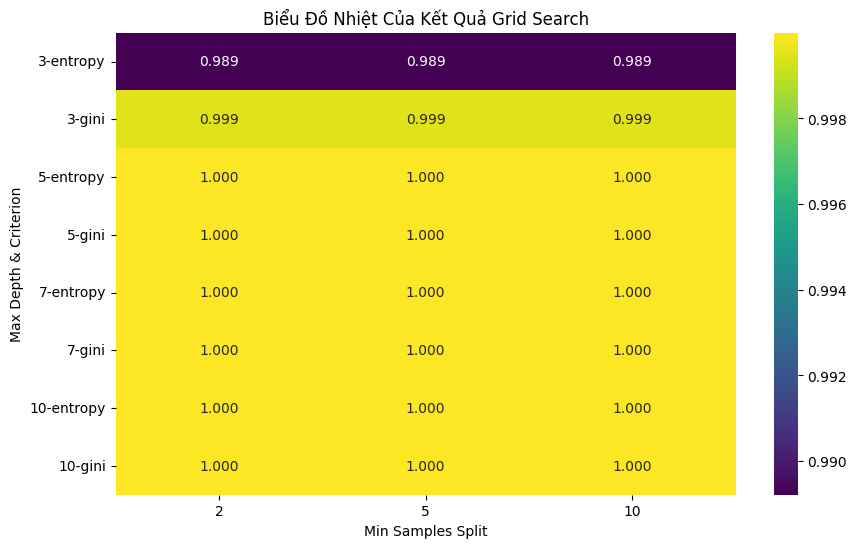

In [17]:
import seaborn as sns
# Chuyển kết quả tìm kiếm lưới thành DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Chọn chỉ các cột quan trọng
important_columns = ['mean_test_score', 'param_max_depth', 'param_min_samples_split', 'param_criterion']

# Lọc kết quả với các cột đã chọn
filtered_results = results[important_columns]

# Tạo pivot table để dễ dàng vẽ biểu đồ
pivot_table = filtered_results.pivot_table(
    values='mean_test_score',
    index=['param_max_depth', 'param_criterion'],
    columns='param_min_samples_split'
)

# Trực quan hóa dữ liệu dưới dạng biểu đồ nhiệt
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
plt.title('Biểu Đồ Nhiệt Của Kết Quả Grid Search')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth & Criterion')
plt.show()

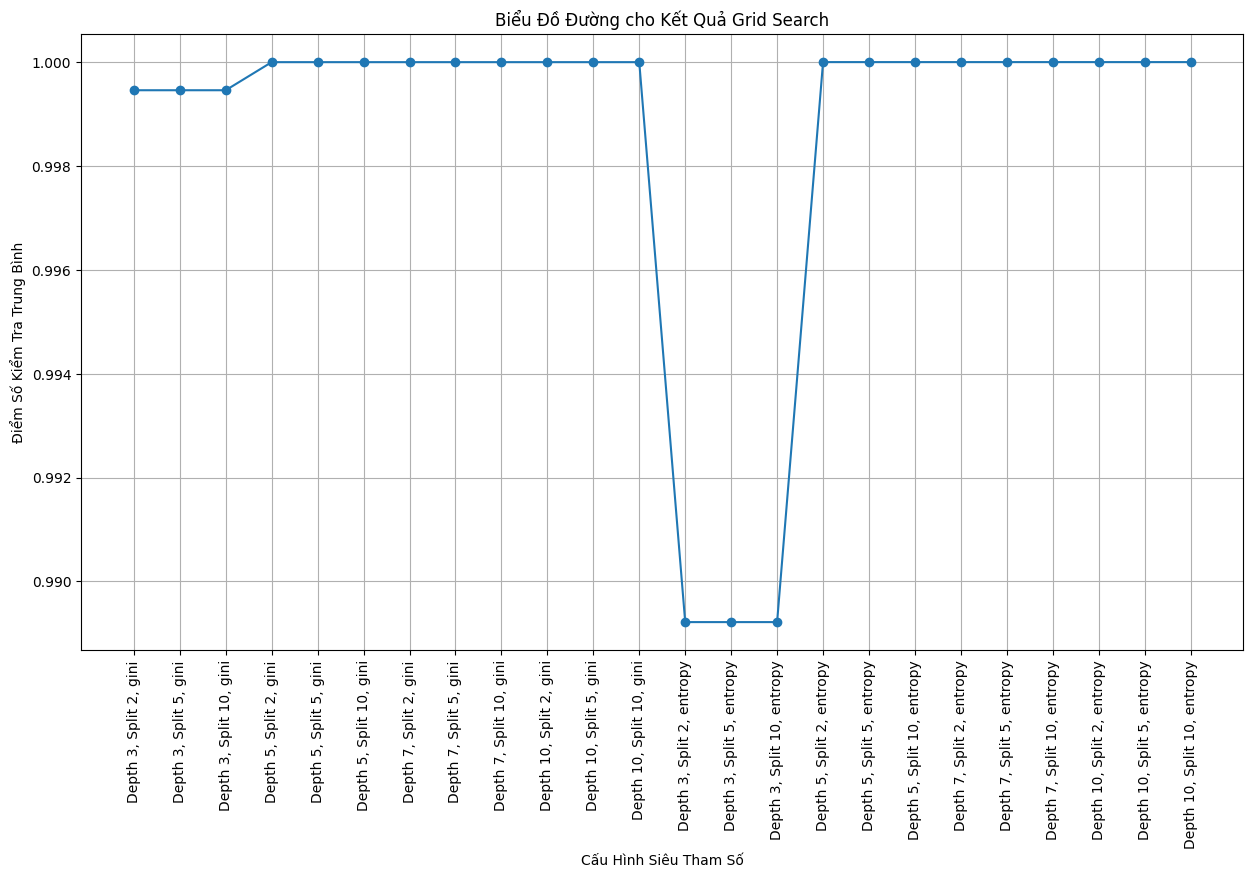

In [18]:
# Chuyển đổi kết quả tìm kiếm lưới thành DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Thêm cột nhận dạng cho mỗi cấu hình siêu tham số
results['case'] = results.apply(lambda row: f"Depth {row['param_max_depth']}, Split {row['param_min_samples_split']}, {row['param_criterion']}", axis=1)

# Vẽ biểu đồ
plt.figure(figsize=(15, 8))
plt.plot(results['case'], results['mean_test_score'], marker='o')

# Đặt các tick trên trục x
plt.xticks(rotation=90)  # Xoay các tick để dễ đọc
plt.title('Biểu Đồ Đường cho Kết Quả Grid Search')
plt.xlabel('Cấu Hình Siêu Tham Số')
plt.ylabel('Điểm Số Kiểm Tra Trung Bình')
plt.grid(True)
plt.show()

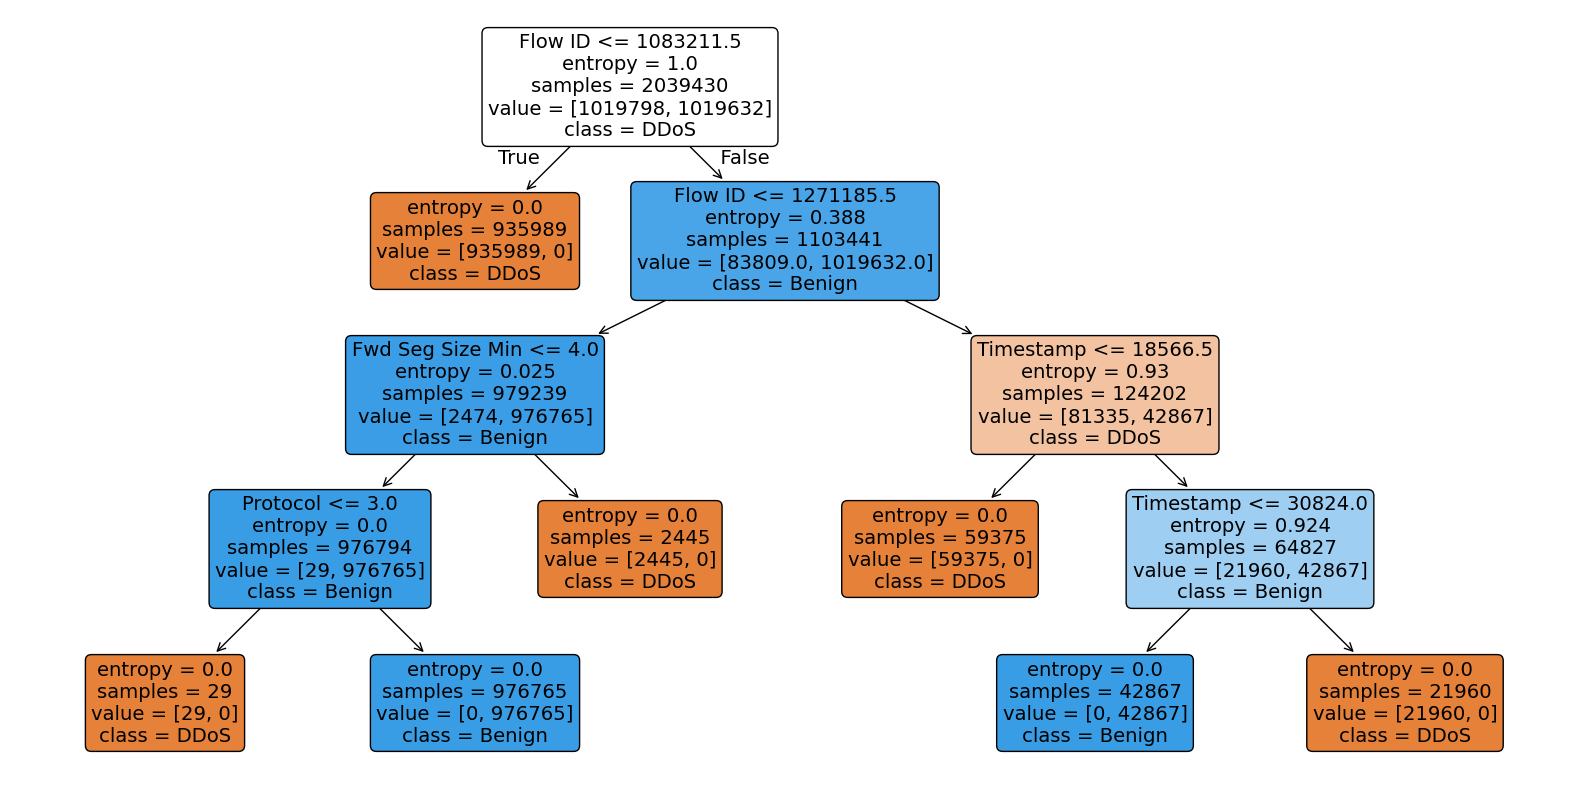

In [19]:
# Vẽ cây quyết định
from sklearn import tree
plt.figure(figsize=(20,10))  # Thiết lập kích thước hình ảnh
tree.plot_tree(best_model,
               filled=True,
               rounded=True,
               class_names=["DDoS", "Benign"],
               feature_names=X.columns)  # Sử dụng tên các đặc trưng trong dữ liệu
plt.show()

In [20]:
# Tính toán độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("accuracy:",accuracy)

accuracy: 1.0


In [21]:
# Tính toán điểm F1
f1score=f1_score(y_test, y_pred)
print("f1-acore:",f1score)

f1-acore: 1.0


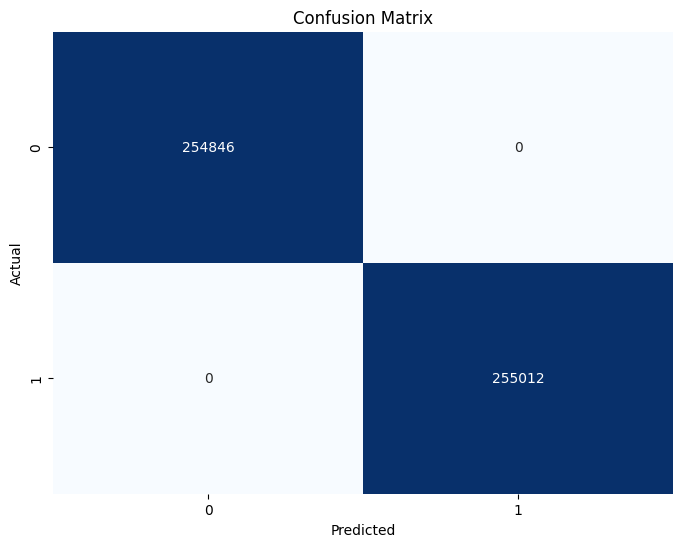

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Tính ma trận nhầm lẫn
confusion = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [23]:
pr=precision_score(y_test,y_pred)
print("Precision:",pr)

rs=recall_score(y_test,y_pred)
print("Recall_score:",rs)

# Tính toán những mẫu mà mô hình dự đoán sai so với nhãn thực tế
misclassified_samples = X_test[y_test != y_pred]
mc=misclassified_samples.shape[0]
print("Misclassified :",mc)

Precision: 1.0
Recall_score: 1.0
Misclassified : 0


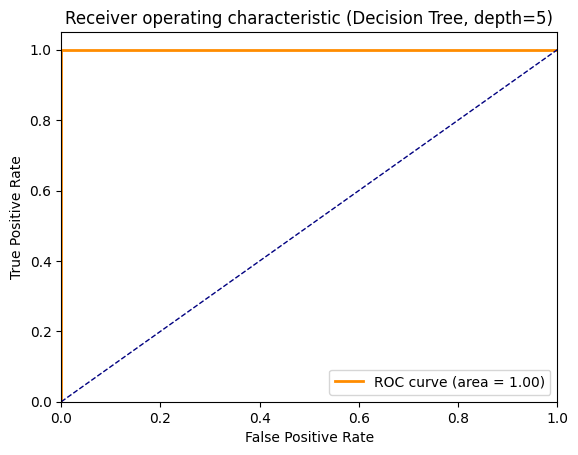

In [24]:
# Vẽ đường cong ROC (Receiver Operating Characteristic)
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (Decision Tree, depth=5)')
plt.legend(loc="lower right")
plt.show()